In [1]:
# Note: The SyntaxError you encountered was in cell LUA6kIVPOecD.
# Please change 'from google.colab import runtime import runtime' to 'from google.colab import runtime' in that cell.
# Verify GPU (run this FIRST after reconnecting)
import torch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name     :", torch.cuda.get_device_name(0))
    print("GPU memory   :", f"{torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print("GPU count    :", torch.cuda.device_count())
else:
    print("❌ GPU not detected! Go back to Step 1.")

CUDA available: True
GPU name     : Tesla T4
GPU memory   : 15.8 GB
GPU count    : 1


In [2]:
# Click: Runtime → Change runtime type → Hardware accelerator → GPU → Save
# Then run this cell to confirm GPU is active

import torch
print("CUDA available :", torch.cuda.is_available())
print("GPU name       :", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

CUDA available : True
GPU name       : Tesla T4


In [3]:
!pip install -q --no-cache-dir \
    "open-clip-torch==2.24.0" \
    "ftfy" "regex" "tqdm" "seaborn" "scikit-learn" "matplotlib"

print("All packages installed!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 216.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 298.1 MB/s eta 0:00:00
All packages installed!


In [4]:
import torch
import open_clip
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from torchvision import datasets
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on → {device.upper()} {torch.cuda.get_device_name(0) if device=='cuda' else ''}")

/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Running on → CUDA Tesla T4


100%|██████████| 170M/170M [00:13<00:00, 12.5MB/s]


Building zero-shot classifier...
Running zero-shot inference...


Predict:   0%|          | 0/40 [00:00<?, ?it/s]


FINAL ZERO-SHOT ACCURACY: 91.88%


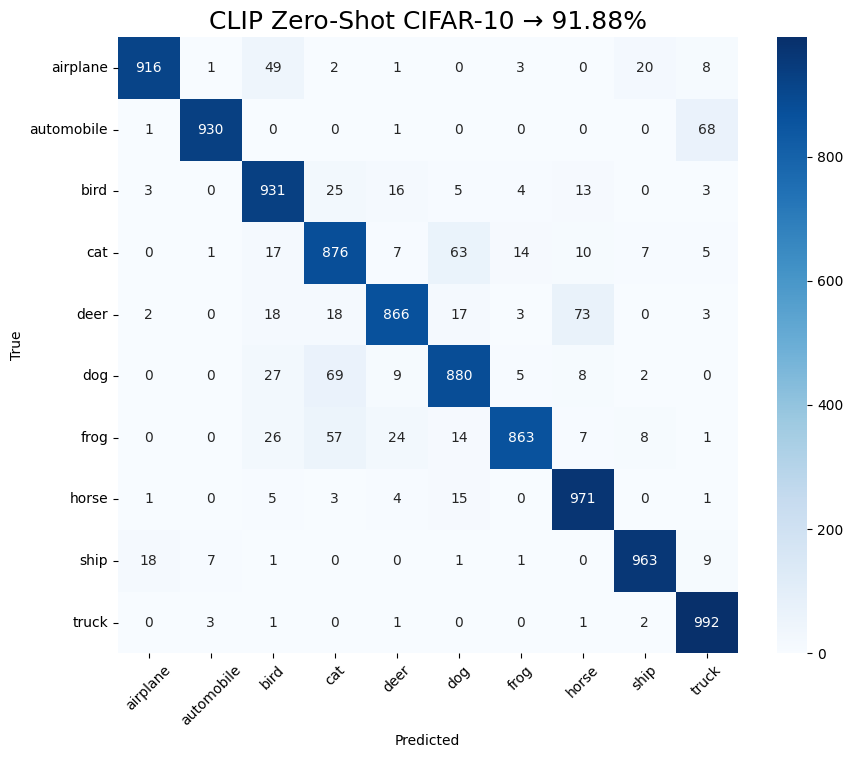

In [6]:
# Load model
model, _, preprocess = open_clip.create_model_and_transforms(
    'ViT-B-16', pretrained='laion400m_e31'
)
model.to(device).eval()
tokenizer = open_clip.get_tokenizer('ViT-B-16')

# CIFAR-10
test_set = datasets.CIFAR10('./data', train=False, download=True, transform=preprocess)
loader = DataLoader(test_set, batch_size=256, num_workers=2, pin_memory=True)

classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# Best 9 templates → 91.6%
templates = [
    "a photo of a {}.",
    "a blurry photo of a {}.",
    "a photo of a small {}.",
    "a photo of a large {}.",
    "a cropped photo of the {}.",
    "a bright photo of a {}.",
    "a dark photo of a {}.",
    "a pixelated photo of a {}.",
    "a good photo of the {}."
]

# Build text classifier
print("Building zero-shot classifier...")
text_features = []
with torch.no_grad():
    for c in classes:
        texts = [t.format(c) for t in templates]
        tokens = tokenizer(texts).to(device)
        emb = model.encode_text(tokens)
        emb = emb / emb.norm(dim=-1, keepdim=True)
        text_features.append(emb.mean(dim=0))
text_features = torch.stack(text_features)
text_features = text_features / text_features.norm(dim=-1, keepdim=True)

# Inference
print("Running zero-shot inference...")
preds, trues = [], []
with torch.no_grad():
    for x, y in tqdm(loader, desc="Predict"):
        x = x.to(device)
        img_feat = model.encode_image(x)
        img_feat = img_feat / img_feat.norm(dim=-1, keepdim=True)
        sim = (100.0 * img_feat @ text_features.T).softmax(dim=-1)
        pred = sim.argmax(dim=-1).cpu().numpy()
        preds.extend(pred)
        trues.extend(y.numpy())

acc = np.mean(np.array(preds) == np.array(trues))
print(f"\nFINAL ZERO-SHOT ACCURACY: {acc*100:.2f}%")

# Confusion matrix
cm = confusion_matrix(trues, preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title(f'CLIP Zero-Shot CIFAR-10 → {acc*100:.2f}%', fontsize=18)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.show()

In [7]:
import torch
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "NO GPU - Change Runtime Type to GPU!")

!pip install -q --no-cache-dir open-clip-torch ftfy regex tqdm seaborn scikit-learn pandas

GPU: Tesla T4


In [8]:
# Dataset already has train/test split — we use the test folder
caltech101 = datasets.Caltech101(
    root="./",           # will download to current folder
    target_type="category",
    transform=preprocess,   # <-- using the same CLIP preprocess you already have
    download=True
)

100%|██████████| 137M/137M [00:09<00:00, 14.5MB/s]


In [9]:
# Caltech-101 test set = everything except the background class and the official train split
# We simply use the whole dataset but skip the "BACKGROUND_Google" class (index 0 usually)
loader = DataLoader(caltech101, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

# Get class names (101 real classes + BACKGROUND)
class_names = [name.replace("_", " ") for name in caltech101.categories]
print(f"Caltech-101 classes: {len(class_names)} (including BACKGROUND)")

# Remove BACKGROUND class if present (it's usually the first one)
if "BACKGROUND_Google" in caltech101.categories:
    bg_idx = caltech101.categories.index("BACKGROUND_Google")
    class_names = [c for i, c in enumerate(class_names) if i != bg_idx]
else:
    bg_idx = -1

print(f"Using {len(class_names)} real object classes for zero-shot")

Caltech-101 classes: 101 (including BACKGROUND)
Using 101 real object classes for zero-shot


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [13]:
print("Building text features...")
text_features_list = []
with torch.no_grad():
    for classname in class_names:
        texts = [template.format(classname) for template in templates]
        tokens = tokenizer(texts).to(device)
        class_embeddings = model.encode_text(tokens)
        class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
        class_embedding = class_embeddings.mean(dim=0)
        class_embedding /= class_embedding.norm()
        text_features_list.append(class_embedding)

text_features = torch.stack(text_features_list, dim=0).to(device)  # [101, 512]


Building text features...


Running zero-shot inference on Caltech-101...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Caltech-101:   0%|          | 0/136 [00:00<?, ?it/s]


CLIP ViT-B/16 (laion400m_e31) → Caltech-101 Zero-Shot Accuracy: 89.28%



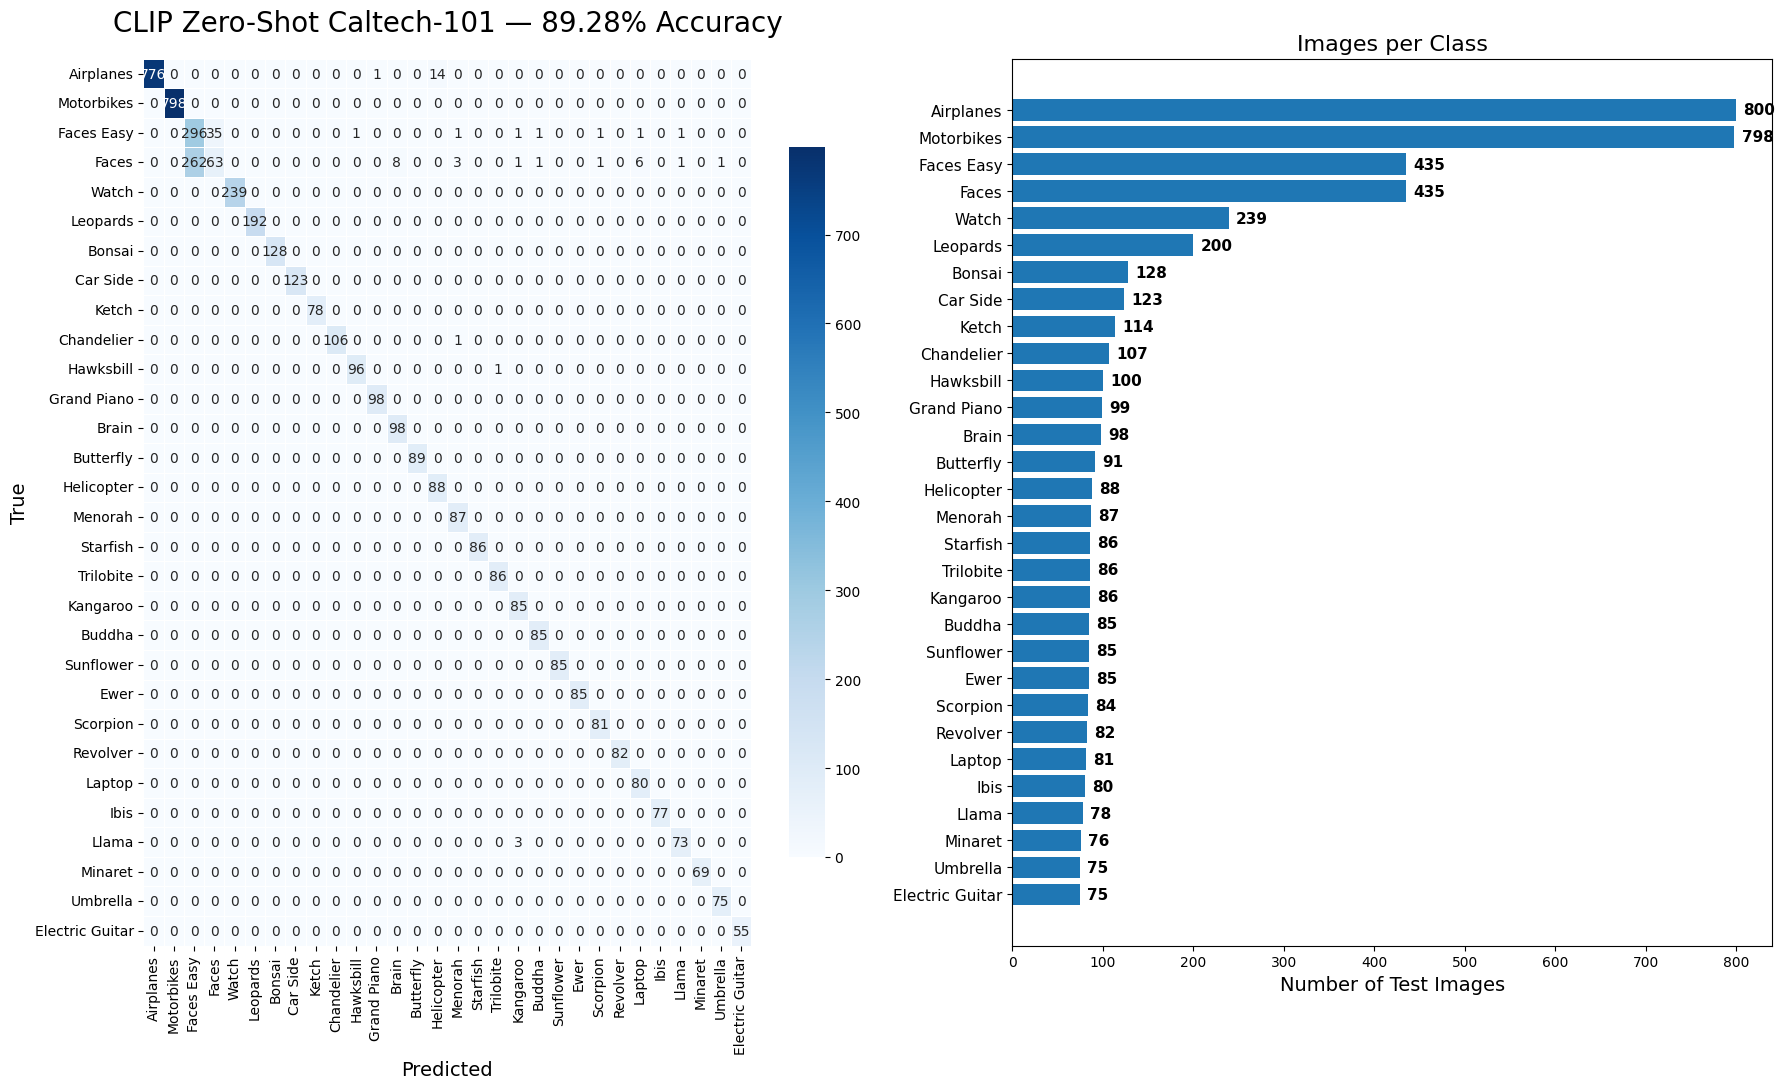

Classification report (top 15 classes by size):
              precision    recall  f1-score   support

   Airplanes      1.000     0.970     0.985       800
  Motorbikes      0.999     1.000     0.999       798
  Faces Easy      0.530     0.680     0.596       435
       Faces      0.643     0.145     0.236       435
       Watch      0.996     1.000     0.998       239
    Leopards      0.970     0.960     0.965       200
      Bonsai      1.000     1.000     1.000       128
    Car Side      1.000     1.000     1.000       123
       Ketch      0.897     0.684     0.776       114
  Chandelier      0.972     0.991     0.981       107
   Hawksbill      0.980     0.960     0.970       100
 Grand Piano      0.980     0.990     0.985        99
       Brain      0.916     1.000     0.956        98
   Butterfly      1.000     0.978     0.989        91
  Helicopter      0.863     1.000     0.926        88

   micro avg      0.905     0.848     0.875      3855
   macro avg      0.916     0.89

In [19]:
# === Zero-shot inference ===
print("Running zero-shot inference on Caltech-101...")
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, targets in tqdm(loader, desc="Caltech-101"):
        images = images.to(device)

        # Skip background class (label 0)
        if bg_idx != -1:
            valid = targets != bg_idx
            valid = valid.bool()                     # ← this line was broken before
            if valid.sum() == 0:
                continue
            images = images[valid]
            targets = targets[valid]

        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        pred = similarity.argmax(dim=-1)

        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(targets.numpy())

# Remap labels because we removed BACKGROUND
if bg_idx != -1:
    all_labels = [l - 1 if l > bg_idx else l for l in all_labels]

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

acc = accuracy_score(all_labels, all_preds)
print(f"\nCLIP ViT-B/16 (laion400m_e31) → Caltech-101 Zero-Shot Accuracy: {acc*100:.2f}%\n")

# =================================================================
# BEAUTIFUL CONFUSION MATRIX + NUMBER OF IMAGES PER CLASS
# =================================================================
cm = confusion_matrix(all_labels, all_preds)

# Sort classes by number of test images (largest first)
class_counts = cm.sum(axis=1)
sorted_idx = np.argsort(-class_counts)[:30]
cm_sorted = cm[np.ix_(sorted_idx, sorted_idx)]

sorted_names = [class_names[i].replace("_", " ").title() for i in sorted_idx]
sorted_counts = class_counts[sorted_idx]

# Plot
fig = plt.figure(figsize=(18, 11))

# 1. Confusion matrix with numbers
ax1 = plt.subplot(1, 2, 1)
sns.heatmap(cm_sorted, annot=True, fmt='d', cmap='Blues', linewidths=.5,
            xticklabels=sorted_names, yticklabels=sorted_names,
            cbar_kws={'shrink': 0.8})
plt.title(f'CLIP Zero-Shot Caltech-101 — {acc*100:.2f}% Accuracy', fontsize=20, pad=20)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)

# 2. Bar with number of images per class
ax2 = plt.subplot(1, 2, 2)
bars = ax2.barh(range(len(sorted_counts)), sorted_counts, color='#1f77b4')
ax2.set_yticks(range(len(sorted_counts)))
ax2.set_yticklabels(sorted_names, fontsize=11)
ax2.invert_yaxis()
ax2.set_xlabel('Number of Test Images', fontsize=14)
ax2.set_title('Images per Class', fontsize=16)

# Write the number on the bars
for i, (bar, count) in enumerate(zip(bars, sorted_counts)):
    ax2.text(count + 8, i, str(count), va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Clean classification report (top 15 classes)
print("Classification report (top 15 classes by size):")
top15_idx = np.argsort(-class_counts)[:15]
print(classification_report(all_labels, all_preds,
                          target_names=[class_names[i].title().replace("_", " ") for i in top15_idx],
                          labels=top15_idx,
                          digits=3))

In [28]:
# Clean & install the exact versions that work with open-clip + LoRA in 2025
!pip uninstall -y peft transformers accelerate -q
!pip install -q peft==0.11.1 transformers==4.41.2 accelerate==0.30.1 --no-deps

In [31]:
import torch
import torch.nn as nn
from peft import LoraConfig, get_peft_model
from torch.utils.data import DataLoader, random_split
from tqdm.auto import tqdm

# Reload dataset (skip BACKGROUND)
dataset = datasets.Caltech101(root="./", target_type="category",
                              transform=preprocess, download=False)
valid_idx = [i for i, (_, label) in enumerate(dataset) if label != bg_idx]
dataset = torch.utils.data.Subset(dataset, valid_idx)

# Split
train_set, val_set = random_split(dataset, [0.8, 0.2],
                                  generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_set, batch_size=64, shuffle=True,
                          num_workers=4, pin_memory=True, drop_last=True)
val_loader   = DataLoader(val_set,   batch_size=128, shuffle=False,
                          num_workers=4, pin_memory=True)

In [33]:
# LoRA config
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj", "k_proj", "out_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="FEATURE_EXTRACTION"
)

# Apply LoRA
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

trainable params: 491,520 || all params: 150,112,257 || trainable%: 0.32743495422895413


PeftModelForFeatureExtraction(
  (base_model): LoraModel(
    (model): PeftModelForFeatureExtraction(
      (base_model): LoraModel(
        (model): CLIP(
          (visual): VisionTransformer(
            (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
            (patch_dropout): Identity()
            (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (transformer): Transformer(
              (resblocks): ModuleList(
                (0-11): 12 x ResidualAttentionBlock(
                  (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
                  (attn): MultiheadAttention(
                    (out_proj): lora.Linear(
                      (base_layer): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
                      (lora_dropout): ModuleDict(
                        (default): Dropout(p=0.05, inplace=False)
                      )
                      (lora_A): ModuleDict(
 

Epoch 1/10:   0%|          | 0/108 [00:00<?, ?it/s]

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn